## Обучение агента

In [1]:
import numpy as np
import collections
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import gymnasium as gym
from vizdoom import gymnasium_wrapper
from gymnasium.wrappers import RecordVideo

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(seed=123)
if use_cuda:
    torch.cuda.manual_seed(seed=123)

img_stack = 12
transition = np.dtype([
                       ('s', [('screen', np.float32, (img_stack, 240, 320)), ('gamevariables', np.float32, (5,))]),
                       ('a', [('binary', np.int16), ('continuous', np.float32, (3,))]),
                       ('a_logp', np.float32),
                       ('r', np.float32),
                       ('s_', [('screen', np.float32, (img_stack, 240, 320)), ('gamevariables', np.float32, (5,))]),
                      ])

In [ ]:
class Env():

    def __init__(self):
        self.env = gym.make('VizdoomDeathmatch-v0')
        self.seed = 123
        self.img_stack = 12
        self.game_var = 1
        self.action_repeat = 8
        self.gamevariables_prev = [0., 100., 0., 2., 50.]

    def reset(self):
        self.counter = 0
        self.die = False
        state, _ = self.env.reset()

        img_rgb = state['screen']
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * self.img_stack

        gamevariables = state['gamevariables']
        self.gv_stack = [gamevariables] * self.game_var
        state = {'screen': np.array(self.stack), 'gamevariables': np.array(self.gv_stack)}
        return state, img_rgb
        
    def step(self, action):
        total_reward = 0

        state, reward, die, _, _ = self.env.step(action)
        img_rgb = state['screen']
        gamevariables = state['gamevariables']

        total_reward += reward
        total_reward += gamevariables[0] - self.gamevariables_prev[0]
        total_reward += gamevariables[1] - self.gamevariables_prev[1]
        total_reward += gamevariables[2] - self.gamevariables_prev[2]
        total_reward += gamevariables[4] - self.gamevariables_prev[4]
        self.gamevariables_prev = gamevariables
        
        self.stack.pop(0)
        self.stack.append(img_rgb[:, :, 0])
        self.stack.pop(0)
        self.stack.append(img_rgb[:, :, 1])
        self.stack.pop(0)
        self.stack.append(img_rgb[:, :, 2])
        self.gv_stack.pop(0)
        self.gv_stack.append(gamevariables)
        assert len(self.stack) == self.img_stack
        assert len(self.gv_stack) == self.game_var
        return np.array(self.stack), np.array(self.gv_stack), total_reward, die, img_rgb

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def rgb2gray(rgb, norm=True):
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            gray = gray / 128. - 1.
        return gray

In [ ]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.img_stack = 12
        self.cnn_base = nn.Sequential(  # input shape (12, 240, 320)
            nn.Conv2d(self.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1)
        )  # output shape (256, 1, 1)
        self.fc_base = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )
        self.binary = nn.Sequential(nn.Linear(320, 18), nn.Softmax(dim=1))
        self.alpha_head = nn.Sequential(nn.Linear(320, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(320, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x, y):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        y = self.fc_base(y)
        z = torch.cat((x, y), dim=1)
        binary = self.binary(z)
        alpha = self.alpha_head(z) + 1
        beta = self.beta_head(z) + 1
        return alpha, beta, binary

In [ ]:
class ValueNet(nn.Module):

    def __init__(self):
        super(ValueNet, self).__init__()
        self.img_stack = 12
        self.cnn_base = nn.Sequential(  # input shape (12, 240, 320)
            nn.Conv2d(self.img_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1)
        )  # output shape (256, 1, 1)
        self.fc_base = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )
        self.value = nn.Sequential(nn.Linear(320, 1))
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x, y):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        y = self.fc_base(y)
        v = torch.cat((x, y), dim=1)
        v = self.value(v)
        return v

In [ ]:
class Agent():

    clip_param = 0.2
    ppo_epoch = 1
    buffer_capacity, batch_size = 1024, 128

    def __init__(self):
        self.training_step = 0
        self.actornet = ActorNet().float().to(device)
        self.valuenet = ValueNet().float().to(device)
        self.buffer = np.empty(self.buffer_capacity, dtype=transition)
        self.counter = 0
        self.gamma = 0.99
        self.lr_actor = 2e-4
        self.lr_value = 2e-4

        self.criterion = nn.CrossEntropyLoss()
        self.actor_optimizer = optim.Adam(self.actornet.parameters(), lr=self.lr_actor)
        self.value_optimizer = optim.Adam(self.valuenet.parameters(), lr=self.lr_value)

    def select_action(self, state):
        state['screen'] = torch.from_numpy(state['screen']).float().to(device) # .unsqueeze(0)
        state['gamevariables'] = torch.from_numpy(state['gamevariables']).float().to(device) # .unsqueeze(0)

        with torch.no_grad():
            alpha, beta, bin = self.actornet(state['screen'], state['gamevariables'])
      
        dist = Beta(alpha, beta)

        binary = torch.argmax(bin, dim=1)
        binary = binary.squeeze().cpu().numpy().item()
        
        continuous = dist.sample()
        a_logp = dist.log_prob(continuous).sum(dim=1).item()
        continuous = continuous.squeeze().cpu().numpy()

        action = {'binary': np.int16(binary), 'continuous': np.array(continuous, dtype=np.float32)}

        return action, a_logp

    def save_param(self):
        torch.save(self.actornet.state_dict(), 'param/ppo_actornet_params.pkl')
        torch.save(self.valuenet.state_dict(), 'param/ppo_valuenet_params.pkl')

    def load_param(self):
        self.actornet.load_state_dict(torch.load('param/ppo_actornet_params.pkl'))
        self.valuenet.load_state_dict(torch.load('param/ppo_valuenet_params.pkl'))

    def store(self, state, action, a_logp, reward, state_):
        
        if (reward != 0) or (self.counter % 2 == 0) or (self.counter % 3 == 0):
            
            transition_state = np.zeros((), dtype=transition)
            transition_state['s']['screen'] = state['screen'].cpu().numpy()
            transition_state['s']['gamevariables'] = state['gamevariables'].cpu().numpy()
            transition_state['a']['binary'] = action['binary']
            transition_state['a']['continuous'] = action['continuous']
            transition_state['a_logp'] = a_logp
            transition_state['r'] = reward
            transition_state['s_']['screen'] = state_['screen']
            transition_state['s_']['gamevariables'] = state_['gamevariables']
            self.buffer[self.counter] = transition_state
            self.counter += 1
        
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1
        s_screen = torch.tensor(np.array(self.buffer['s']['screen']).copy(), dtype=torch.float32).to(device)
        s_gv = torch.tensor(np.array(self.buffer['s']['gamevariables']).copy(), dtype=torch.float32).to(device)
        s = collections.OrderedDict({'screen': s_screen, 'gamevariables': s_gv})
        for key in s.keys():
            s[key] = s[key].to(device)
        a_binary = torch.tensor(np.array(self.buffer['a']['binary']).copy(), dtype=torch.int16)
        a_continuous = torch.tensor(np.array(self.buffer['a']['continuous']).copy(), dtype=torch.float32)
        a = collections.OrderedDict({'binary': a_binary, 'continuous': a_continuous})
        for key in a.keys():
            a[key] = a[key].to(device)
        r = torch.tensor(np.array(self.buffer['r']).copy(), dtype=torch.float32).to(device).view(-1, 1)
        s_screen_ = torch.tensor(np.array(self.buffer['s_']['screen']).copy(), dtype=torch.float32).to(device)
        s_gv_ = torch.tensor(np.array(self.buffer['s_']['gamevariables']).copy(), dtype=torch.float32).to(device)
        s_ = collections.OrderedDict({'screen': s_screen_, 'gamevariables': s_gv_})
        for key in s_.keys():
            s_[key] = s_[key].to(device)

        old_binary = torch.tensor(np.array(self.buffer['a']['binary']).copy(), dtype=torch.float32).to(device).view(-1, 1)
        old_a_logp_cont = torch.tensor(np.array(self.buffer['a_logp']).copy(), dtype=torch.float32).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + self.gamma * self.valuenet(s_['screen'], s_['gamevariables'])
            adv = target_v - self.valuenet(s['screen'], s['gamevariables'])
            # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                alpha, beta, binary = self.actornet(s['screen'][index], s['gamevariables'][index])

                # ratio_bin = torch.exp(torch.log(binary) - torch.log(old_binary[index]))
                ratio_bin = binary - old_binary[index]
                surr1_bin = ratio_bin * adv[index]
                surr2_bin = torch.clamp(ratio_bin, 1 - self.clip_param, 1 + self.clip_param) * adv[index]
                binary_loss = -torch.min(surr1_bin, surr2_bin).mean()
                
                dist = Beta(alpha, beta)
                a_logp_cont = dist.log_prob(a['continuous'][index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp_cont - old_a_logp_cont[index])
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                
                value_loss = F.smooth_l1_loss(self.valuenet(s['screen'][index], s['gamevariables'][index]), target_v[index])
                
                loss = action_loss + value_loss + binary_loss

                self.actor_optimizer.zero_grad()
                self.value_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                self.value_optimizer.step()

In [ ]:
agent = Agent()
env = Env()

log_interval = 10
reward_threshold = 100

reward_records = []
running_score = 0

In [ ]:
for i_ep in range(10_000):
    score = 0
    state, img_rgb = env.reset()
    for t in range(10_000):
        action, a_logp = agent.select_action(state)
        state_s_, state_gv_, reward, die, img_rgb_ = env.step(action)
        state_ = {'screen': state_s_, 'gamevariables': state_gv_}

        if agent.store(state, action, a_logp, reward, state_):
            print(f'Обновление, эпизод {i_ep+1}\tСкользящий средний score: {running_score:.2f}                                   ')
            agent.update()
        score += reward
        state = state_
        if die: # done or
            break
    running_score = running_score * 0.99 + score * 0.01
    reward_records.append(score)

    print(f'Эпизод {i_ep+1}\tПоследний score: {score:.2f}\tСкользящий средний score: {running_score:.2f}\tt: {t}        ', end='\r')
    agent.save_param()
    
    if running_score > reward_threshold:
        print(f'Обучение остановлено. Эпизод {i_ep+1}\tПоследний score: {score:.2f}\tСкользящий средний score: {running_score:.2f}')
        break

Обновление, эпизод 13	Скользящий средний score: -0.83                                                                      
Обновление, эпизод 36	Скользящий средний score: 0.12                                                                      
Обновление, эпизод 56	Скользящий средний score: 0.74                                                                      
Обновление, эпизод 76	Скользящий средний score: 1.79                                                                      
Обновление, эпизод 97	Скользящий средний score: 2.32                                                                      
Обновление, эпизод 113	Скользящий средний score: 2.78                                                                      
Обновление, эпизод 132	Скользящий средний score: 3.02                                                                      
Обновление, эпизод 151	Скользящий средний score: 3.43                                                                      
Обновление, 

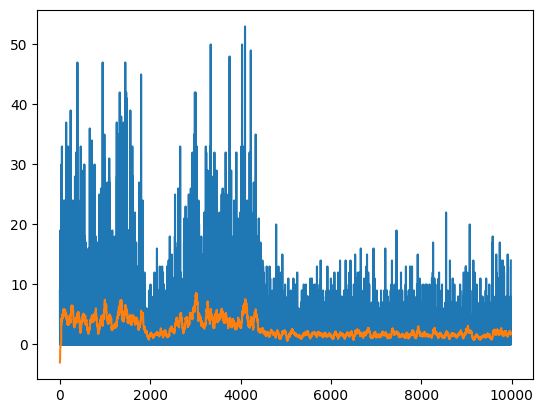

In [27]:
# Generate recent 50 interval average
average_reward = []
for idx in range(20, len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records[20:])
plt.plot(average_reward)

## Тестирование агента

In [11]:
import os
import PIL
import shutil as sh
from glob import glob
from base64 import b64encode
from datetime import datetime

In [ ]:
env_dir = './vizdoom-videos'
if not os.path.exists(env_dir):
    os.makedirs(env_dir)

In [13]:
def record_episode(eps_frames, records_dir, exp_id, eps_num):
    record_path = os.path.join(records_dir, f'record-{exp_id}_eps-{eps_num}.mp4')
    eps_frame_dir = './vizdoom-videos/episode_frames'
    if not os.path.exists(eps_frame_dir):
        os.mkdir(eps_frame_dir)

    for i, frame  in enumerate(eps_frames):
        PIL.Image.fromarray(frame).save(os.path.join(eps_frame_dir, f'frame-{i+1}.png'))

    os.system(f'ffmpeg -r 30 -i {eps_frame_dir}/frame-%1d.png -vcodec libx264 -b 10M -y "{record_path}"');
    sh.rmtree(eps_frame_dir)


def show_episode_records(records_dir):
    record_paths = glob(os.path.join(records_dir, "*.mp4"))
    html_str = ''
    for i, record_path in enumerate(record_paths):
        mp4 = open(record_path, 'rb').read()
        data = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        html_str += f'EPISODE # {i+1}<br><video width=500 controls><source src="{data}" type="video/mp4"></video><br><br>'
    return HTML(html_str)


In [ ]:
def run_episode(env, agent):
    state, img_rgb = env.reset()
    step_count = 0
    frames = list()
    done = False
    frames.append(img_rgb)
    while not done:
        action, _ = agent.select_action(state)
        next_state, reward, done, img_rgb_ = env.step(action)
        frames.append(img_rgb_)
        state = next_state
        step_count += 1

    return frames

def evaluate_agent(env, agent, exp_dir, n_eval=5):
    for eps_num in range(1, n_eval + 1):
        eps_frames = run_episode(env, agent)
        print('frames =', len(eps_frames))
        record_episode(eps_frames, exp_dir, f'exp-{datetime.now().strftime("%d%m-%H%M%S")}', eps_num)

In [ ]:
evaluate_agent(env, agent, env_dir)